In [56]:
import os
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_hub as hub
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.utils.class_weight import compute_class_weight


def load_data(dataset_path):
    X, y = [], []

    class_names = [f for f in os.listdir(dataset_path) if not f.startswith('.')]
    class_names.sort()

    for class_label, class_dir in enumerate(class_names):
        class_path = os.path.join(dataset_path, class_dir)
        if os.path.isdir(class_path):
            for wav_file in os.listdir(class_path):
                if wav_file.endswith('.wav'):
                    wav_path = os.path.join(class_path, wav_file)
                    wav, sr = librosa.load(wav_path, sr=16000)
                    # wav = augment(samples=wav, sample_rate=sr)  # Comment out or remove this line
                    X.append(wav)
                    y.append(class_label)

    return np.array(X, dtype=object), np.array(y), class_names






In [2]:

yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)





2023-09-22 01:39:11.264238: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-09-22 01:39:11.264267: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-09-22 01:39:11.264275: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-09-22 01:39:11.264509: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-22 01:39:11.264532: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [65]:


def extract_features(model, X):
    features = []
    for wav in X:
        scores, embeddings, spectrogram = model(wav)
        features.append(embeddings.numpy().mean(axis=0))
    return np.array(features)

# Load data and extract features
X, y, class_names = load_data('/Users/ankush/Downloads/deakin-units/data/combined_audio')  # Replace with your dataset path
X_features = extract_features(yamnet_model, X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2, random_state=42)

# Encode labels to integers
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [59]:
import os

def get_species_from_folders(parent_directory):
    """Extracts the subfolder names from a given directory."""
    subfolders = [f.name for f in os.scandir(parent_directory) if f.is_dir()]
    return subfolders

def main():
    parent_directory = '/Users/ankush/Downloads/deakin-units/data/final_training'  # replace with your folder path
    species_list = get_species_from_folders(parent_directory)
    
    for species in species_list:
        print(species)

if __name__ == "__main__":
    main()


Malleefowl
Vanellus miles
Spotted Nightjar
Grey Teal
Pheasant Coucal
Tiger quoll
coyote
Peaceful Dove
capra hirus
Pacific Swift
Orange footed Scrubfowl
Large-tailed Nightjar
Little Bronze Cuckoo
Felis Catus
common pheasant
Australian Lyrebird
Uperoleia laevigata
Sus scrofa Wild Pig
Australian Brushturkey
Rattus
Pacific Koel


In [66]:


# Calculate class weights
unique_classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=unique_classes, y=y_train)
class_weights_dict = dict(enumerate(class_weights))




# Build and train a new model
model = models.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_features.shape[1],)),
   
    layers.Dense(64, activation='relu'),
    
    layers.Dense(len(class_names), activation='softmax'), # Use class_names to determine the number of outputs
])




model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

# Define early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Training the model
history = model.fit(X_train, y_train, 
                    epochs=150, 
                    batch_size=64, 
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping, model_checkpoint],
                    class_weight=class_weights_dict)  # Adding class weights here

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print("\nTest accuracy:", test_acc)



Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 128)               131200    
                                                                 
 dense_34 (Dense)            (None, 64)                8256      
                                                                 
 dense_35 (Dense)            (None, 21)                1365      
                                                                 
Total params: 140821 (550.08 KB)
Trainable params: 140821 (550.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/150


2023-09-22 14:32:30.325703: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-22 14:32:30.362533: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


220/220 [==============================] - ETA: 0s - loss: 1.5382 - accuracy: 0.5701

2023-09-22 14:32:32.776634: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


220/220 [==============================] - 3s 12ms/step - loss: 1.5382 - accuracy: 0.5701 - val_loss: 1.0232 - val_accuracy: 0.7032
Epoch 2/150
 11/220 [>.............................] - ETA: 2s - loss: 1.0222 - accuracy: 0.7102

/Users/ankush/anaconda3/envs/new_env2/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


220/220 [==============================] - 2s 8ms/step - loss: 0.8979 - accuracy: 0.7385 - val_loss: 0.8784 - val_accuracy: 0.7277
Epoch 3/150
220/220 [==============================] - 2s 8ms/step - loss: 0.7626 - accuracy: 0.7724 - val_loss: 0.7721 - val_accuracy: 0.7725
Epoch 4/150
220/220 [==============================] - 2s 8ms/step - loss: 0.7049 - accuracy: 0.7909 - val_loss: 0.7446 - val_accuracy: 0.7739
Epoch 5/150
220/220 [==============================] - 2s 8ms/step - loss: 0.6543 - accuracy: 0.8057 - val_loss: 0.7198 - val_accuracy: 0.7813
Epoch 6/150
220/220 [==============================] - 2s 8ms/step - loss: 0.6087 - accuracy: 0.8182 - val_loss: 0.7044 - val_accuracy: 0.7950
Epoch 7/150
220/220 [==============================] - 2s 7ms/step - loss: 0.5840 - accuracy: 0.8244 - val_loss: 0.6788 - val_accuracy: 0.7993
Epoch 8/150
220/220 [==============================] - 2s 7ms/step - loss: 0.5630 - accuracy: 0.8323 - val_loss: 0.6516 - val_accuracy: 0.8104
Epoch 9/150

In [61]:
model.save('model_3_82_16000.h5')

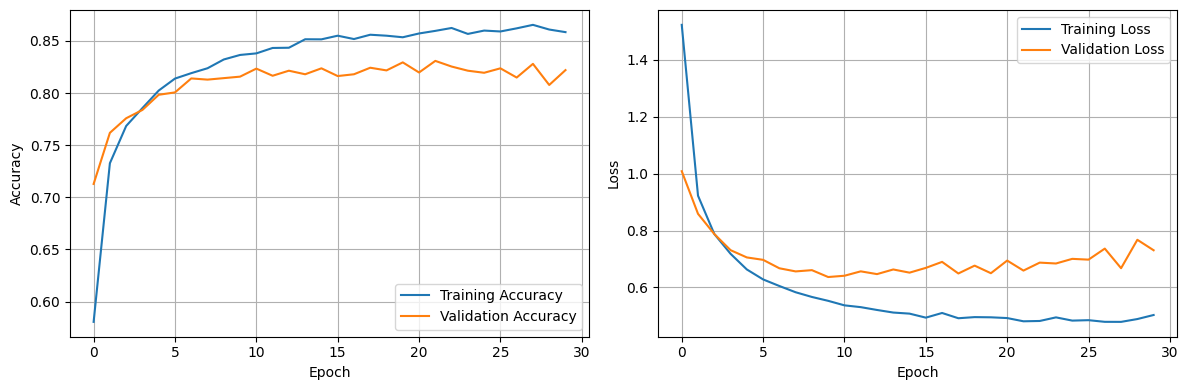

Model saved successfully.


In [62]:
import matplotlib.pyplot as plt

# Continuing from the previous part...

# Plotting the training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Saving the trained model
#model.save('animal_sound_classification_model.h5')

print("Model saved successfully.")

#  (Next, we can work on loading the saved model and using it for predictions in a separate script or later in your current script)


 32/110 [=======>......................] - ETA: 0s

2023-09-22 14:16:13.570817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


110/110 [==============================] - 0s 3ms/step


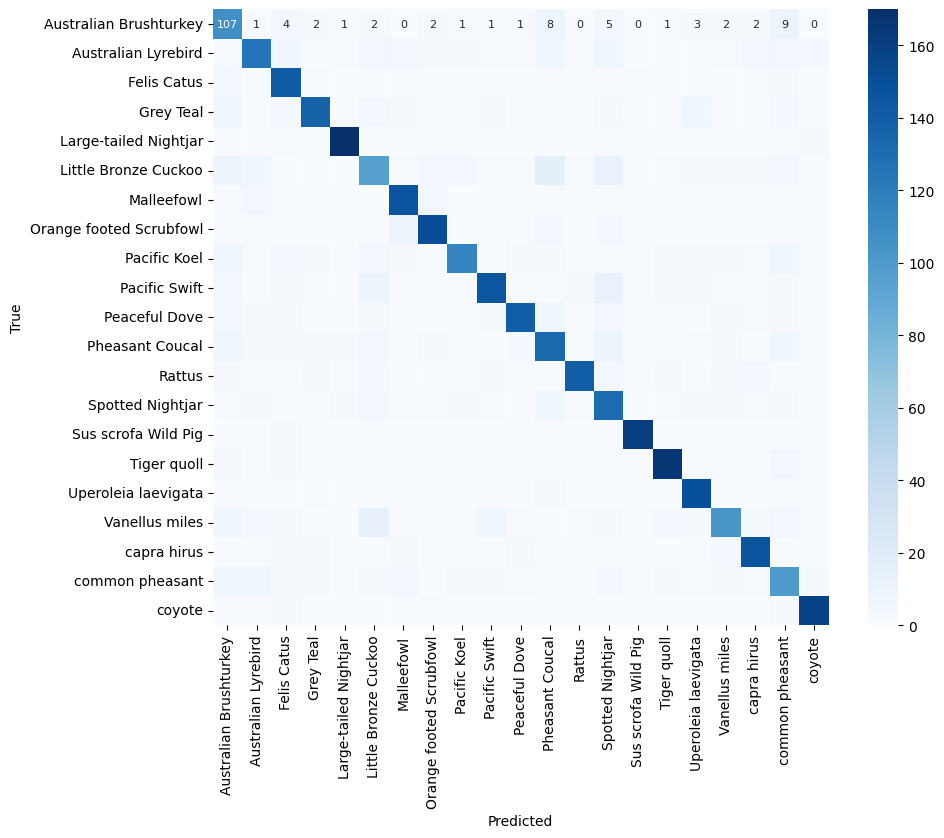

                         precision    recall  f1-score   support

 Australian Brushturkey       0.61      0.70      0.65       152
    Australian Lyrebird       0.78      0.71      0.74       177
            Felis Catus       0.77      0.91      0.83       156
              Grey Teal       0.88      0.79      0.83       174
  Large-tailed Nightjar       0.96      0.95      0.95       179
   Little Bronze Cuckoo       0.61      0.57      0.59       167
             Malleefowl       0.83      0.91      0.87       162
Orange footed Scrubfowl       0.86      0.87      0.87       173
           Pacific Koel       0.87      0.72      0.79       160
          Pacific Swift       0.88      0.78      0.83       185
          Peaceful Dove       0.89      0.81      0.85       173
        Pheasant Coucal       0.70      0.73      0.71       182
                 Rattus       0.97      0.83      0.89       167
       Spotted Nightjar       0.64      0.79      0.71       166
    Sus scrofa Wild Pig 

In [63]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# ... (After training your model)

# Predict the classes of the validation set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Create a confusion matrix
confusion_mtx = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10,8))  # Adjust the size as needed

ax=sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            annot_kws={"size": 8})  # Adjust size as needed
ax.set_aspect('equal') 
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print a classification report
print(classification_report(y_test, y_pred_classes, target_names=class_names))


In [14]:
pwd


'/Users/ankush/Downloads/deakin-units/yamnets/2-chunk model'

In [64]:
import pickle

# Save the class_names and LabelEncoder object after training your model
with open('class_names.pkl', 'wb') as f:
    pickle.dump(class_names, f)

with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)


## Test model on 2 sec chunk

In [15]:
import pickle
import librosa
import numpy as np
import tensorflow_hub as hub
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model

# Define the function to load a single audio file
def load_audio_file(file_path):
    wav, sr = librosa.load(file_path, sr=16000)
    return np.array([wav])

# Define the function to extract features
def extract_features(model, X):
    features = []
    for wav in X:
        scores, embeddings, spectrogram = model(wav)
        features.append(embeddings.numpy().mean(axis=0))
    return np.array(features)

# Load the class names and LabelEncoder object
with open('class_names.pkl', 'rb') as f:
    class_names = pickle.load(f)

with open('label_encoder.pkl', 'rb') as f:
    le = pickle.load(f)

# Load the YAMNet model
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

# Load your trained model
#model = load_model('model76.h5')

# Load a single audio file and extract features
# Replace 'path/to/your/audiofile.wav' with the actual path to your audio file
X_new = load_audio_file('/Users/ankush/Downloads/deakin-units/data/cleaned3/Felis Catus/cat_30-0_chunk-0_segment-remaining.wav')  
X_new_features = extract_features(yamnet_model, X_new)

# Make predictions
predictions = model.predict(X_new_features)

# Get the top two probabilities and their respective class indices
top_two_prob_indices = np.argsort(predictions[0])[-2:]
top_two_prob_values = predictions[0][top_two_prob_indices]

# Convert class indices to class names
top_two_class_names = le.inverse_transform(top_two_prob_indices)

# Print the top two class names along with their probabilities
# Print the top two class names along with their probabilities
for i in range(2):
    print(f"Class: {class_names[top_two_prob_indices[1-i]]}, Probability: {top_two_prob_values[1-i]:.2f}")


1/1 [==============================] - 0s 66ms/step
Class: Felis Catus, Probability: 1.00
Class: collared Brushturkey, Probability: 0.00
